In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import torch
import math
import torchvision
import matplotlib.pyplot as plt

In [2]:
def load_dataset(data_dir, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
        ])
    data_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
    return data_loader

In [3]:
class Encoder(nn.Module):
    def __init__(self, fan_in, fan_out, hidden_dim):
        super(Encoder, self).__init__()
        
        self.fan_in = fan_in
        self.hidden_dim = hidden_dim
        self.fan_out = fan_out

        self.hidden_layer = nn.Linear(fan_in, hidden_dim)

        self.mu_layer = nn.Linear(hidden_dim, fan_out)
        self.log_std_layer = nn.Linear(hidden_dim, fan_out)

        self.unmasked_layer = nn.Linear(hidden_dim, fan_out * fan_out)
        self.mask = torch.tril(torch.ones(fan_out, fan_out), diagonal=-1)
        self.register_buffer('mask_const', self.mask)

    def forward(self, x):
        hidden_output = F.relu(self.hidden_layer(x))
        mu_output = self.mu_layer(hidden_output)
        log_std_output = self.log_std_layer(hidden_output)

        unmasked_layer_output = self.unmasked_layer(hidden_output)
        unmasked_layer_output = unmasked_layer_output.view(-1, self.fan_out, self.fan_out)

        stanndard_deviation_output = torch.exp(log_std_output)
        lower_triangular_matrix = unmasked_layer_output * self.mask_const + torch.diag_embed(stanndard_deviation_output)
        
        eps = torch.randn_like(stanndard_deviation_output)
        z = mu_output + torch.bmm(lower_triangular_matrix, eps.view(-1, self.fan_out, 1)).view(-1, self.fan_out)
        return z, eps, log_std_output

In [4]:
class Decoder(nn.Module):
    def __init__(self, fan_in, fan_out, hidden_dim):
        super(Decoder, self).__init__()

        self.fan_in = fan_in
        self.hidden_dim = hidden_dim
        self.fan_out = fan_out

        self.hidden_layer = nn.Linear(fan_in, hidden_dim)

        self.output_layer = nn.Linear(hidden_dim, fan_out)

    def forward(self, z):
        hidden_output = F.relu(self.hidden_layer(z))
        output = F.sigmoid(self.output_layer(hidden_output))

        return output

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, fan_in=28*28, hidden_dim=1024, latent_dim=2):
        super(VariationalAutoEncoder, self).__init__()

        self.fan_in = fan_in
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(fan_in, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, fan_in, hidden_dim)

    def forward(self, x):
        z, eps, log_std_output = self.encoder(x)
        x_reconstructed = self.decoder(z)

        return x_reconstructed, z, eps, log_std_output

In [6]:
def compute_negative_evidence_lower_bound(x, x_reconstructed, z, eps, log_std):
    log_2pi = math.log(2 * math.pi)

    # Reconstruction Loss
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(
        x_reconstructed, x, reduction="sum"
    )

    # Variational Posterior Term
    latent_loss_q = 0.5 * torch.sum(eps**2 + log_std + log_2pi)

    # Prior Term
    prior_loss = 0.5 * torch.sum(z**2 + log_2pi)

    # ELBO and Negative ELBO
    elbo = -reconstruction_loss - prior_loss + latent_loss_q
    negative_elbo = -elbo

    # Average Negative ELBO
    batch_size = x.size(0)
    average_negative_elbo = negative_elbo / batch_size

    return average_negative_elbo

In [7]:
def get_lr(step, warmup_steps, max_lr, min_lr, max_steps):
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    elif step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

In [8]:
def train():
    VAE = VariationalAutoEncoder()

    data_dir = "data"
    checkpoint_dir = "checkpoints"
    images_generated_dir = "images_generated"
    batch_size = 128
    epochs = 50
    warmup_steps = 5
    max_steps = 50
    max_lr = 1e-3
    min_lr = 0.01 * max_lr
    lr = max_lr
    num_samples = 16
    
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(images_generated_dir, exist_ok=True)
    data_loader = load_dataset(data_dir, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    VAE.to(device)
    
    optimizer = torch.optim.Adam(VAE.parameters(), lr=lr)

    VAE.train()
    for epoch in range(epochs):
        epoch_loss =  0
        for batch in tqdm(data_loader):
            lr = get_lr(epoch, warmup_steps, max_lr, min_lr, max_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            optimizer.zero_grad()
            x, labels = batch
            x = x.to(device)
            x = x.view(-1, 28 * 28)
            x_reconstructed, z, eps, log_std_output = VAE(x)
            loss = compute_negative_evidence_lower_bound(x, x_reconstructed, z, eps, log_std_output)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / len(data_loader)
        print(f"{epoch + 1} / {epochs} ---> Loss : {epoch_loss:.4f}")

        if (epoch+1) % 10 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': VAE.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)

        with torch.no_grad():
            sample = torch.randn(num_samples, VAE.latent_dim).to(device)
            sample = VAE.decoder(sample).cpu()
            torchvision.utils.save_image(sample.view(num_samples, 1, 28, 28), os.path.join(images_generated_dir, f"images_generated_{epoch+1}.png"))

In [9]:
train()

  0%|          | 0/469 [00:00<?, ?it/s]

1 / 50 ---> Loss : 211.0139


  0%|          | 0/469 [00:00<?, ?it/s]

2 / 50 ---> Loss : 172.6332


  0%|          | 0/469 [00:00<?, ?it/s]

3 / 50 ---> Loss : 164.1703


  0%|          | 0/469 [00:00<?, ?it/s]

4 / 50 ---> Loss : 159.2665


  0%|          | 0/469 [00:00<?, ?it/s]

5 / 50 ---> Loss : 155.7194


  0%|          | 0/469 [00:00<?, ?it/s]

6 / 50 ---> Loss : 152.8396


  0%|          | 0/469 [00:00<?, ?it/s]

7 / 50 ---> Loss : 150.9223


  0%|          | 0/469 [00:00<?, ?it/s]

8 / 50 ---> Loss : 149.3810


  0%|          | 0/469 [00:00<?, ?it/s]

9 / 50 ---> Loss : 148.1543


  0%|          | 0/469 [00:00<?, ?it/s]

10 / 50 ---> Loss : 147.1290


  0%|          | 0/469 [00:00<?, ?it/s]

11 / 50 ---> Loss : 146.2919


  0%|          | 0/469 [00:00<?, ?it/s]

12 / 50 ---> Loss : 145.4905


  0%|          | 0/469 [00:00<?, ?it/s]

13 / 50 ---> Loss : 144.7527


  0%|          | 0/469 [00:00<?, ?it/s]

14 / 50 ---> Loss : 144.0833


  0%|          | 0/469 [00:00<?, ?it/s]

15 / 50 ---> Loss : 143.4829


  0%|          | 0/469 [00:00<?, ?it/s]

16 / 50 ---> Loss : 142.9048


  0%|          | 0/469 [00:00<?, ?it/s]

17 / 50 ---> Loss : 142.4119


  0%|          | 0/469 [00:00<?, ?it/s]

18 / 50 ---> Loss : 141.8650


  0%|          | 0/469 [00:00<?, ?it/s]

19 / 50 ---> Loss : 141.3849


  0%|          | 0/469 [00:00<?, ?it/s]

20 / 50 ---> Loss : 140.9182


  0%|          | 0/469 [00:00<?, ?it/s]

21 / 50 ---> Loss : 140.4720


  0%|          | 0/469 [00:00<?, ?it/s]

22 / 50 ---> Loss : 140.0990


  0%|          | 0/469 [00:00<?, ?it/s]

23 / 50 ---> Loss : 139.7159


  0%|          | 0/469 [00:00<?, ?it/s]

24 / 50 ---> Loss : 139.3084


  0%|          | 0/469 [00:00<?, ?it/s]

25 / 50 ---> Loss : 138.9347


  0%|          | 0/469 [00:00<?, ?it/s]

26 / 50 ---> Loss : 138.6046


  0%|          | 0/469 [00:00<?, ?it/s]

27 / 50 ---> Loss : 138.2830


  0%|          | 0/469 [00:00<?, ?it/s]

28 / 50 ---> Loss : 137.9510


  0%|          | 0/469 [00:00<?, ?it/s]

29 / 50 ---> Loss : 137.6586


  0%|          | 0/469 [00:00<?, ?it/s]

30 / 50 ---> Loss : 137.3420


  0%|          | 0/469 [00:00<?, ?it/s]

31 / 50 ---> Loss : 137.0634


  0%|          | 0/469 [00:00<?, ?it/s]

32 / 50 ---> Loss : 136.7991


  0%|          | 0/469 [00:00<?, ?it/s]

33 / 50 ---> Loss : 136.5350


  0%|          | 0/469 [00:00<?, ?it/s]

34 / 50 ---> Loss : 136.2965


  0%|          | 0/469 [00:00<?, ?it/s]

35 / 50 ---> Loss : 136.1116


  0%|          | 0/469 [00:00<?, ?it/s]

36 / 50 ---> Loss : 135.8839


  0%|          | 0/469 [00:00<?, ?it/s]

37 / 50 ---> Loss : 135.6872


  0%|          | 0/469 [00:00<?, ?it/s]

38 / 50 ---> Loss : 135.5110


  0%|          | 0/469 [00:00<?, ?it/s]

39 / 50 ---> Loss : 135.3583


  0%|          | 0/469 [00:00<?, ?it/s]

40 / 50 ---> Loss : 135.2038


  0%|          | 0/469 [00:00<?, ?it/s]

41 / 50 ---> Loss : 135.0839


  0%|          | 0/469 [00:00<?, ?it/s]

42 / 50 ---> Loss : 134.9587


  0%|          | 0/469 [00:00<?, ?it/s]

43 / 50 ---> Loss : 134.8825


  0%|          | 0/469 [00:00<?, ?it/s]

44 / 50 ---> Loss : 134.7866


  0%|          | 0/469 [00:00<?, ?it/s]

45 / 50 ---> Loss : 134.7067


  0%|          | 0/469 [00:00<?, ?it/s]

46 / 50 ---> Loss : 134.6556


  0%|          | 0/469 [00:00<?, ?it/s]

47 / 50 ---> Loss : 134.5996


  0%|          | 0/469 [00:00<?, ?it/s]

48 / 50 ---> Loss : 134.5610


  0%|          | 0/469 [00:00<?, ?it/s]

49 / 50 ---> Loss : 134.5407


  0%|          | 0/469 [00:00<?, ?it/s]

50 / 50 ---> Loss : 134.5131


In [10]:
def test():
    checkpoint_dir = "checkpoints"
    num_samples = 4

    VAE = VariationalAutoEncoder()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    VAE.to(device)
    
    checkpoint_path = os.path.join(checkpoint_dir, "vae_epoch_30.pth")
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    VAE.load_state_dict(checkpoint['model_state_dict'])
    VAE.eval()

    samples = torch.randn(num_samples, VAE.latent_dim).to(device)
    results = VAE.decoder(samples).view(num_samples, 28, 28).detach().cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2.5))
    for i, ax in enumerate(axes):
        ax.imshow(results[i], cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

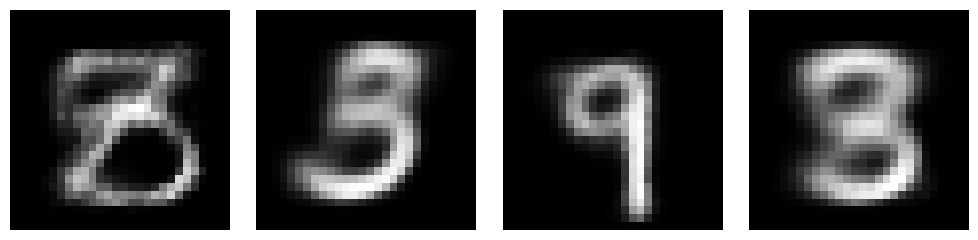

In [11]:
test()